<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">Authors</div>Luis Antonio Ortega Andrés<br>Antonio Coín Castro</div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [155]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [156]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell imports the packages to be used.

In [157]:
import numpy as np
import math
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D
Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment consists in implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning methods.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should a value in `[0,1]`.
* This method should only store the parameters in fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to computed the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

**TODO**

- Signo determinista en los autovectores (algo como esto que es de sklearn.exmath):
```python
def _deterministic_vector_sign_flip(u):
    """Modify the sign of vectors for reproducibility.
    Flips the sign of elements of all the vectors (rows of u) such that
    the absolute maximum element of each vector is positive.
    Parameters
    ----------
    u : ndarray
        Array with vectors as its rows.
    Returns
    -------
    u_flipped : ndarray with same shape as u
        Array with the sign flipped vectors as its rows.
    """
    max_abs_rows = np.argmax(np.abs(u), axis=1)
    signs = np.sign(u[range(u.shape[0]), max_abs_rows])
    u *= signs[:, np.newaxis]
    return u
```

- Rellenar el transform(X) con Nystroem (inspiración [aquí?](https://pydiffmap.readthedocs.io/en/master/_modules/pydiffmap/diffusion_map.html#nystroem_oos)).
- Comprobar que está bien, por ejemplo, sabiendo que sklearn.manifold.SpectralEmbedding con rbf es equivalente a DiffusionMaps con rbf, alpha=0 y step=0.
- Rellenar función diffusion_distance para que devuelva una matriz de distancias en el espacio original (usando la fórmula aproximada). Comparar fuera con la matriz de distancias euclídeas y ver que coinciden.
- Comprobar que estamos eligiendo bien el sigma en la función _choose_sigma.
- "Cross validation" con los casos de prueba (distintos kernels, alphas, step,...). **IMPORTANTE**: estandarizar datos a media 0 y std 1 por columnas (?).
- Comentar y organizar el código (reproducir estructura de [sklearn](https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/manifold/_spectral_embedding.py)).
- Responder a las preguntas del final.

In [188]:
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import (
    rbf_kernel, laplacian_kernel, pairwise_distances
)


class DiffusionMaps(BaseEstimator):
    """Diffusion Maps algorithm for manifold learning [1].

    We use the data to define a weighted graph based on  
    kernel similarity, then define a random walk over the graph, 
    and finally use the transition probabilities to find an 
    embedding to a lower-dimensional space. 

    [1] Coifman, R. R., & Lafon, S. (2006). Diffusion maps. 
        Applied and computational harmonic analysis, 21(1), 5-30.
    """

    def __init__(
        self,
        n_components=2,
        step=1,
        alpha=1.0,
        affinity='rbf',
        sigma='median'   # 'median', 'maximum', 'auto', float
    ):
        self.n_components = n_components
        self.step = step
        self.alpha = alpha
        self.affinity = affinity
        self.sigma = sigma

    def _choose_sigma(self, X):
        """
            Handles the initialization of sigma.
        """
        if self.sigma == 'median':
            self.sigma_ = np.median(pairwise_distances(X))
        elif self.sigma == 'maximum':
            self.sigma_ = np.max(pairwise_distances(X))
        elif self.sigma == 'auto':
            self.sigma_ = np.sqrt(X.shape[1]/2.)
        elif isinstance(self.sigma, (int, float)):
            self.sigma_ = self.sigma
        else:
            raise ValueError(("%s is not a valid sigma parameter. "
                              "Expected 'median', 'maximum', 'auto' "
                              "or a float.") % self._sigma)
    def _choose_n_components(self):
        """
            Handles the initialization of the number of components, i.e, the
            dimensionality of the reduction. 
            
            In case a float value is used in declaration,
            ```
            n\_components = \argmin_{l} |\lambda_l| <= \delta |\lambda_0|^T
            ```
        """
        if isinstance(self.n_components, int):
            self.n_components_ = self.n_components
        elif isinstance(self.n_components, float):
            self.n_components_ = np.argmin(
                                  np.abs(self.eigvals)**self.step >
                                  self.n_components*np.abs(self.eigvals[0])**self.step
                                )
        else:
            raise ValueError(("%s is not a valid n_components parameter. \
                              Expected int of float.") % self.n_components)

    def _get_affinity_matrix(self, X, y = None):

        # y = X when y is not specified.
        y = y or X
        
        if self.affinity == 'rbf':
            return rbf_kernel(X, y, gamma=1/(2*self.sigma_**2))
        
        if self.affinity == 'laplacian':
            return laplacian_kernel(X, y, gamma=1/(2*self.sigma_**2))
        if self.affinity == 'precomputed':
            return X

        # affinity is a function by its own
        return self.affinity(X, y)

    def _diagonalize(self, M):
        # Get eigenvalues and left eigenvectors
        eigvals, eigvecs = np.linalg.eig(M)

        # Check that complex part is negligible and ignore it
        if np.iscomplexobj(eigvals):
            threshold_imaginary_part = 1e-6
            max_imaginary_part = np.max(
                np.abs(np.imag(eigvals))
            )

            if max_imaginary_part > threshold_imaginary_part:
                warnings.warn(
                    "Maximum imaginary part is {}".format(
                        max_imaginary_part)
                )

            eigvals = np.real(eigvals)
            eigvecs = np.real(eigvecs)

        # Sort in descending order and ignore first position
        idx = eigvals.argsort()[::-1]

        return eigvals[idx], eigvecs[:, idx]

    def fit(self, X, y=None):
        """Compute the embedding vectors for data X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored

        Returns
        -------
        self : returns an instance of self.
        """
        self.X = X
        self._choose_sigma(X)

        if isinstance(self.affinity, str):
            if self.affinity not in {"rbf", "laplacian", "precomputed"}:
                raise ValueError(("%s is not a valid kernel. Expected "
                                  "'precomputed', 'rbf', 'laplacian' "
                                  "or a callable.") % self.affinity)
        elif not callable(self.affinity):
            raise ValueError(("'affinity' is expected to be a kernel "
                              "name or a callable. Got: %s") % self.affinity)

        # Compute affinity matrix
        self._affinity_matrix = self._get_affinity_matrix(X)

        # Degree diagonal matrix
        self._degree_v = np.sum(self._affinity_matrix, axis=1)**(-self.alpha)
        Dv = np.diag(self._degree_v)

        # Density normalization
        L_alpha = Dv@self._affinity_matrix@Dv

        # Transition probability matrix
        P = (L_alpha/np.sum(L_alpha, axis=1)).T

        # Eigendecomposition of P
        self.eigvals, self.eigvecs = self._diagonalize(P)
        self._choose_n_components()

        self.eigvals = self.eigvals[1:self.n_components_ + 1]
        self.eigvecs = self.eigvecs[:, 1:self.n_components_ + 1]
        
        """
        # Conjugate matrix of P
        Dvv = np.diag(np.sqrt(np.sum(L_alpha, axis=1))**-1)
        A = Dvv@L_alpha@Dvv
        A = (A + A.T)/2.
        a_vals, a_vecs = np.linalg.eigh(A)
        print(np.linalg.norm(
            eigvecs[:, 0]*np.sqrt(X.shape[0]) - a_vecs[:, -2]/a_vecs[:, -1]))
        """

        # Embedding
        self.embedding_ = (self.eigvals**self.step)*self.eigvecs

        return self

    def diffusion_distance():
        pass
        """
        # Define diffusion matrix 
        D = pdist((self.eigvals**self.step)*self.eigvecs, metric='sqeuclidean')
        D = squareform(D)
        """

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        self.fit(X)
        return self.embedding_

    def transform(self, Xnew):
        """Transform X.
        This is implemented using the Nyström formula.
        Parameters
        ----------
        Xnew : array-like, shape (n_samples, n_features).
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        
        K = self._get_affinity_matrix(self.X, Xnew)
        D = self._degree_v.T@np.sum(K, axis=0)
        
        
        
        return 1/self.eigvals * self.eigvecs @ (K/D)

## Pruebas rápidas

Coincide con SpectralEmbedding con los parámetros adecuados.

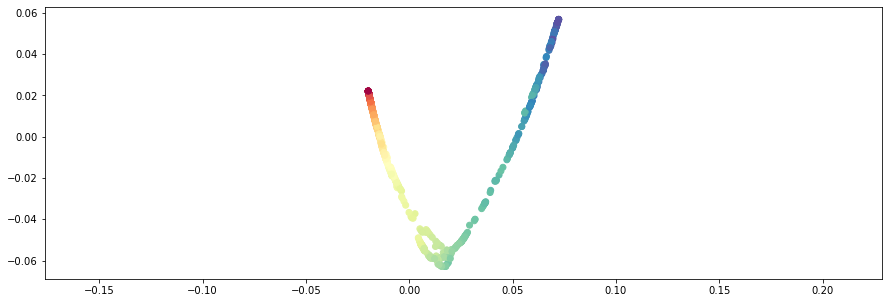

In [189]:
N = 1000
X, color = make_swiss_roll(N, random_state=seed)

dm = DiffusionMaps(n_components=2, sigma=1.0, step=0, alpha=0)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

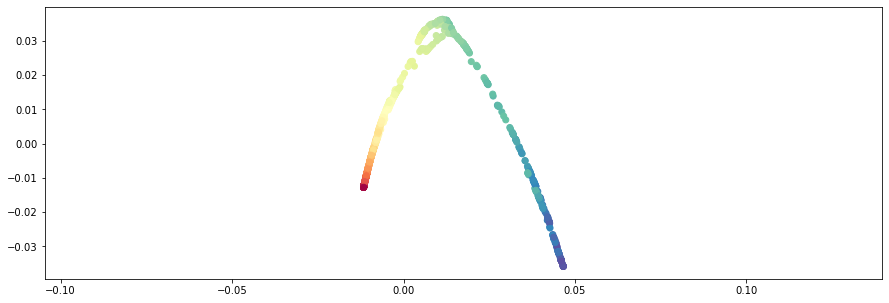

In [162]:
from sklearn.manifold import SpectralEmbedding

se = SpectralEmbedding(affinity='rbf', gamma=0.5)
X_red = se.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

## Dataset 1: two blobs

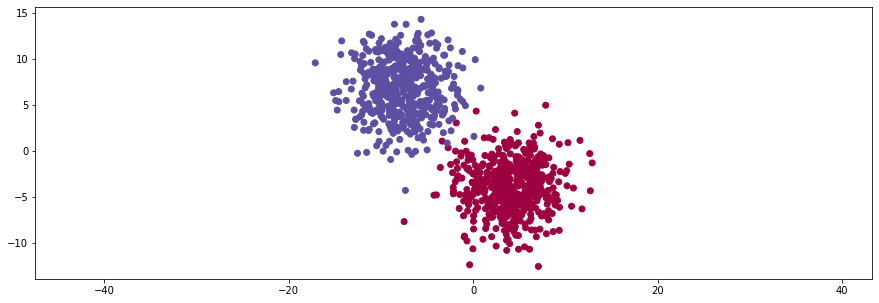

In [50]:
N = 1000

X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
y[y != 1] = -1
plt.scatter(X[:,0], X[:,1], c=y, cmap=my_cmap)
plt.axis('equal')
plt.show()

N_new=100
X_new, y_new = make_blobs(n_samples=N_new, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed+1)

In [54]:
dm = DiffusionMaps(n_components=1, sigma='median')
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 45.34276701094178


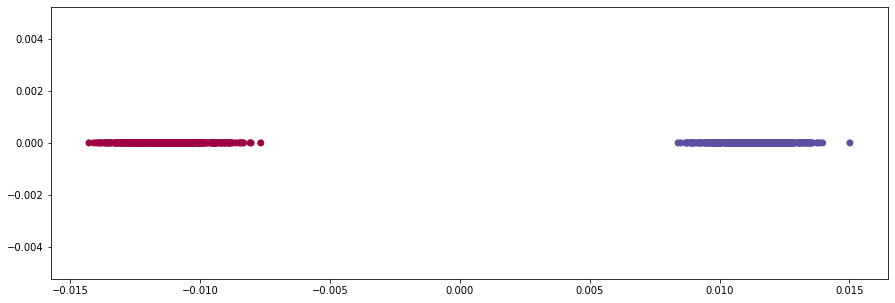

In [56]:
plt.scatter(X_red, np.zeros(X_red.shape[0]), c=y, cmap=my_cmap)
plt.axis('equal')
plt.show()

## Dataset 2: the swiss roll

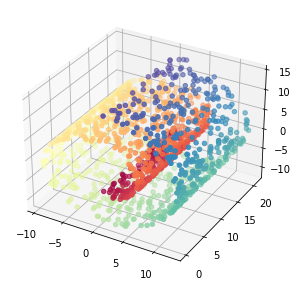

In [57]:
N=1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new=100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed+1)

In [58]:
dm = DiffusionMaps(n_components=2, sigma=2.5)
X_red = dm.fit_transform(X)

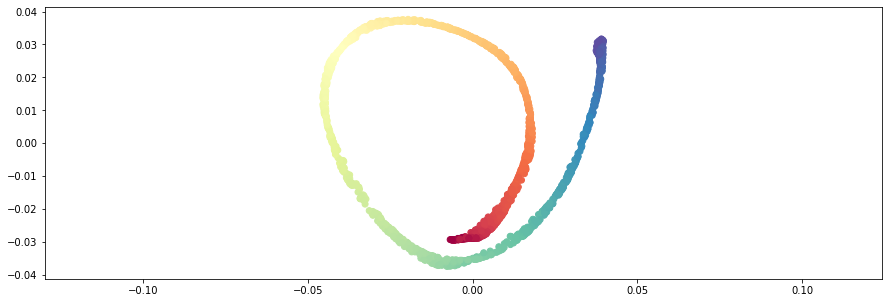

In [59]:
plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

## Dataset 3: the S curve

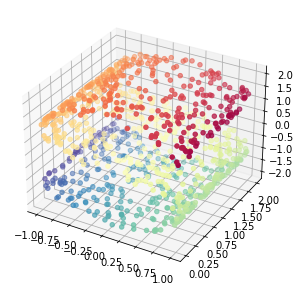

In [60]:
N = 1000
X, color = make_s_curve(N, random_state=seed)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed+1)

In [61]:
dm = DiffusionMaps(n_components=2)
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 2.015761643396546


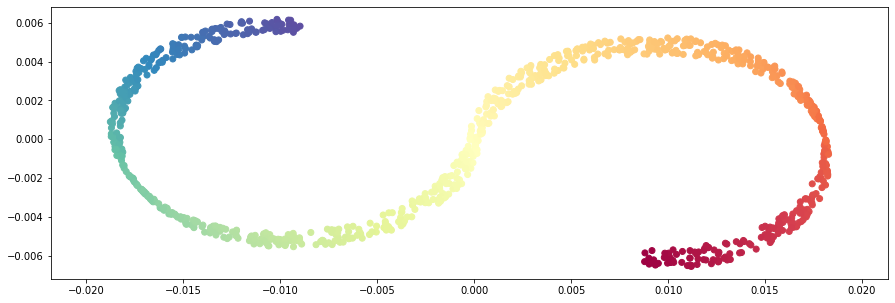

In [62]:
plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

<div class="qst">

* Do you consider the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
* How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
    
* What do you think are the main advantage and disadvantage of this method?
    
</div>